In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from classical_approach import *
root_path = Path().resolve().parents[1]
data_path = root_path / "data"
halos_path = data_path / "halos.pkl"

## The Data

Just doing some quick investigation of the data. It appears that there are 79 galaxies/halos in total. The data to read in is a tuple: `(particle_info, halo_info)`.

The quantity we would like to predict is `GroupStellarMass`, I believe.

In [3]:

data = load_data(data_path)

mean_predictors = data["train_predictors"].mean(axis=0, keepdims=True)
std_predictors = data["train_predictors"].std(axis=0, keepdims=True)

train_transformed = (data["train_predictors"] - mean_predictors) / std_predictors
test_transformed = (data["test_predictors"] - mean_predictors) / std_predictors

nuts_kernel = NUTS(linear_regression)


mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=1)
mcmc.run(rng, train_transformed, data["train_labels"])
samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 5000/5000 [00:04<00:00, 1037.62it/s, 7 steps of size 6.71e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      9.54      0.02      9.54      9.51      9.57   4059.25      1.00
  slopes[0]      0.17      0.02      0.17      0.14      0.20   4307.00      1.00
  slopes[1]     -0.03      0.02     -0.03     -0.07     -0.00   3868.77      1.00
        std      0.14      0.01      0.14      0.11      0.16   3100.43      1.00

Number of divergences: 0


/home/daniel/mambaforge-pypy3/envs/pyot/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


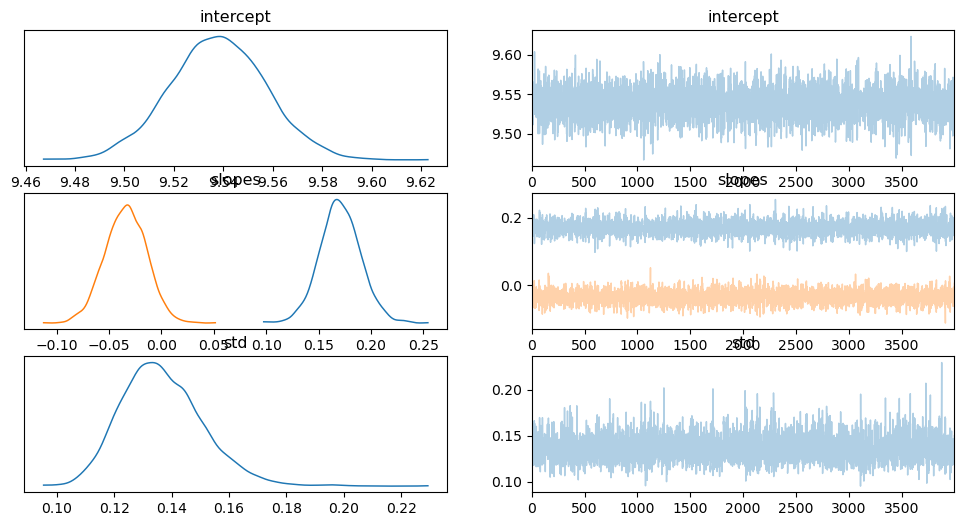

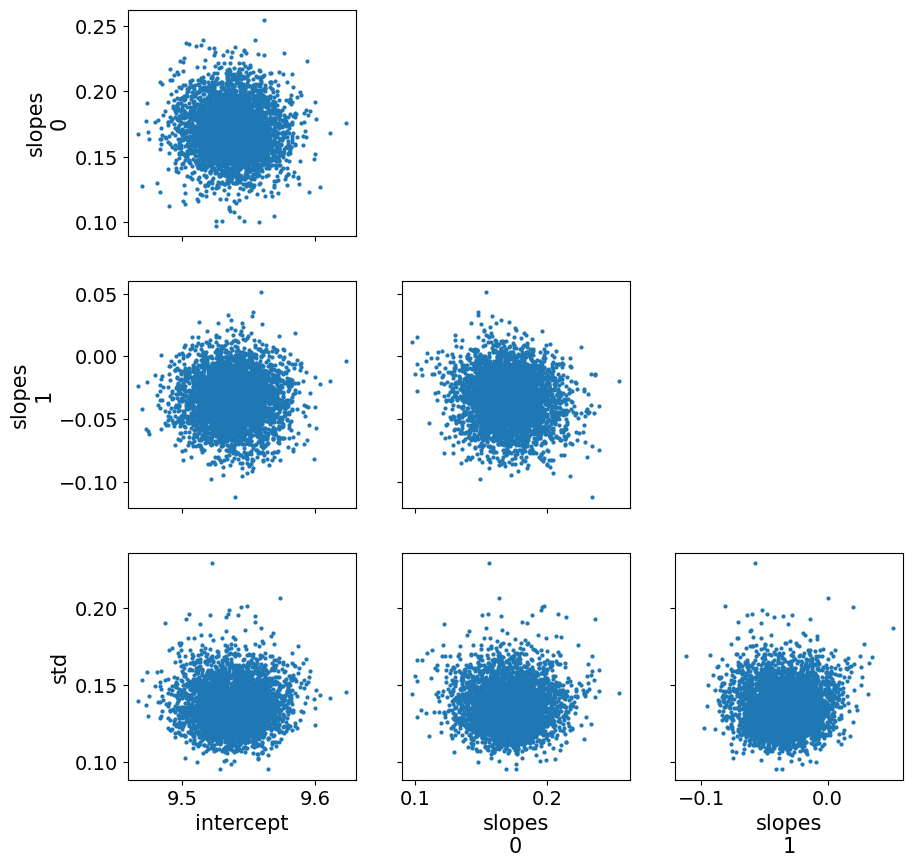

In [4]:
# Checking trace of output
posterior = az.from_numpyro(mcmc)
az.plot_trace(posterior);
az.plot_pair(posterior, figsize=(10, 10));

In [5]:
# Now let's see what the predictions are:
predictive_distribution = Predictive(linear_regression, samples)

# This is predictions on the training data, which we've already seen:
# However, I'm not too worried about it being overfit, since it's a Bayesian model,
# So our estimate of the loss should be pretty good.
predictions = predictive_distribution(rng, train_transformed)

jnp.sqrt(
    jnp.mean(
        jnp.square(jnp.mean(predictions["predictions"], axis=0) - data["train_labels"])
    )
)

Array(0.12852885, dtype=float32)

In [6]:
def oat_cross_validation(train_predictors, train_labels):
    n_train = train_predictors.shape[0]
    residuals = []
    for i in range(n_train):
        linear_regression = LinearRegression()
        linear_regression.fit(jnp.delete(train_predictors, i, axis=0), jnp.delete(train_labels, i))
        prediction = linear_regression.predict(jnp.array([train_predictors[i]]))
        residuals.append(prediction - train_labels[i])
    
    return jnp.sqrt(jnp.mean(jnp.square(jnp.array(residuals))))


oat_cross_validation(data["train_predictors"], data["train_labels"])

# Okay, this is meaningfully worse than the RMSE when we predicted on seen data.
# But it's still better than the KNN predictions.


Array(0.13923672, dtype=float32)

In [8]:
linear_regression = LinearRegression()
linear_regression.fit(data["train_predictors"], data["train_labels"])
linear_regression.coef_[1] / linear_regression.coef_[0]

-0.8485307